# Cifar-10 이미지 분류

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np

In [2]:
# seed 값 설정
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# 나중에 지정될 변수의 값을 미리 세팅
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 100
DATA_AUGMENTATION = True
NUM_PREDICTIONS = 20
SAVE_DIR = os.path.join(os.getcwd(), 'model')
MODEL_NAME = 'keras_cifar10_trained_model.h5'

In [4]:
# The data, split between train and test sets:
(x_train, y_train0), (x_test, y_test0) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### 데이터 확인 및 전처리

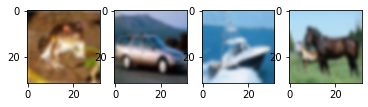

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(141)
plt.imshow(x_train[0], interpolation="bicubic")
plt.subplot(142)
plt.imshow(x_train[4], interpolation="bicubic")
plt.subplot(143)
plt.imshow(x_train[8], interpolation="bicubic")
plt.subplot(144)
plt.imshow(x_train[12], interpolation="bicubic")
plt.grid(False)
plt.show()

In [6]:
y_train0[0]

array([6], dtype=uint8)

In [7]:
# 자료형을 실수로 변환한 후 정규화
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [8]:
# One-hot encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train0, NUM_CLASSES)
y_test = to_categorical(y_test0, NUM_CLASSES)
y_train.shape, y_test.shape

((50000, 10), (10000, 10))

### 모델 정의/설정/학습

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [10]:
from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(learning_rate=0.0001, decay=1e-6)

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
modelpath = "model/cifar10-cnn-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=10)

In [13]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    shuffle=True,
                    callbacks=[early_stopping_callback, checkpointer])

Epoch 1/100
1250/1250 [==============================] - 9s 5ms/step - loss: 2.0578 - accuracy: 0.2352 - val_loss: 1.6259 - val_accuracy: 0.4204

Epoch 00001: val_loss improved from inf to 1.62586, saving model to model/cifar10-cnn-01-1.6259.hdf5
Epoch 2/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6166 - accuracy: 0.4071 - val_loss: 1.4915 - val_accuracy: 0.4601

Epoch 00002: val_loss improved from 1.62586 to 1.49147, saving model to model/cifar10-cnn-02-1.4915.hdf5
Epoch 3/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.4529 - accuracy: 0.4731 - val_loss: 1.3681 - val_accuracy: 0.5197

Epoch 00003: val_loss improved from 1.49147 to 1.36811, saving model to model/cifar10-cnn-03-1.3681.hdf5
Epoch 4/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3626 - accuracy: 0.5079 - val_loss: 1.2441 - val_accuracy: 0.5684

Epoch 00004: val_loss improved from 1.36811 to 1.24409, saving model to model/cifar10-cnn-04-1.2441.hdf5


In [14]:
from tensorflow.keras.models import load_model
best_model = load_model('./model/cifar10-cnn-50-0.6529.hdf5')

In [15]:
# 테스트 정확도 출력 
acc = model.evaluate(x_test, y_test, verbose=2)[1]
print(f"\n Test Accuracy: {acc:.4f}")

313/313 - 1s - loss: 0.6937 - accuracy: 0.7758

 Test Accuracy: 0.7758


### 훈련과정 시각화

In [16]:
# 검증셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']

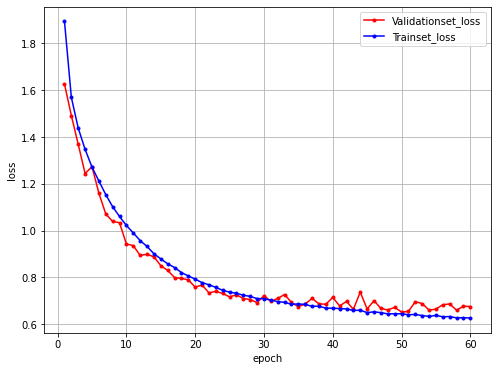

In [17]:
# 그래프로 표현
x_len = np.arange(1, len(y_loss)+1)
plt.figure(figsize=(8,6))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Validationset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()